# Shipment Forecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error as mae, mean_absolute_percentage_error as mape
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from scipy.optimize import minimize
from boruta import BorutaPy

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import xgboost as xgb
import lightgbm as lgb

from fbprophet import Prophet

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 

## Data loading

In [164]:
pos_data = pd.read_csv('data/pos.csv')
pos_data.head()

,Date,Sales
0,2011-01-01,266.0
1,2011-02-01,145.9
2,2011-03-01,183.1
3,2011-04-01,119.3
4,2011-05-01,180.3


In [165]:
promo_data = pd.read_csv('data/promo.csv', header=None)
promo_data.head()

,0,1
0,2011-11-01,BlackFriday
1,2012-11-01,BlackFriday
2,2013-11-01,BlackFriday


In [166]:
shipment_data = pd.read_csv('data/shipment.csv')
shipment_data.head()

,Date,Shipments
0,2011-01-01,100
1,2011-02-01,319
2,2011-03-01,247
3,2011-04-01,238
4,2011-05-01,214


## Data exploration

### Set Date as index

In [167]:
pos_data.Date = pd.to_datetime(pos_data.Date)

promo_data.rename({0:'Date', 1:'BlackFriday'}, axis=1, inplace=True)
promo_data.Date = pd.to_datetime(promo_data.Date)

shipment_data.Date = pd.to_datetime(shipment_data.Date)

In [168]:
pos_data = pos_data.set_index('Date')
promo_data = promo_data.set_index('Date')
shipment_data = shipment_data.set_index('Date')

### Missing values

In [8]:
pos_data.isna().sum()

Sales    0
dtype: int64

In [9]:
promo_data.isna().sum()

BlackFriday    0
dtype: int64

In [10]:
shipment_data.isna().sum()

Shipments    0
dtype: int64

### Missing month

In [11]:
pos_data.asfreq('MS').isna().sum()

Sales    0
dtype: int64

In [12]:
shipment_data.asfreq('MS').isna().sum()

Shipments    0
dtype: int64

### Combine dataframes into one

In [169]:
data = pd.concat([pos_data, promo_data, shipment_data], axis=1)
data.BlackFriday = data.BlackFriday.replace("BlackFriday", 1)
data = data.fillna(0)
data

,Sales,BlackFriday,Shipments
Date,,,
2011-01-01,266.0,0.0,100
2011-02-01,145.9,0.0,319
2011-03-01,183.1,0.0,247
2011-04-01,119.3,0.0,238
2011-05-01,180.3,0.0,214
2011-06-01,168.5,0.0,188
2011-07-01,231.8,0.0,195
2011-08-01,224.5,0.0,209
2011-09-01,192.8,0.0,241


### Sales and Shipments time-series graph

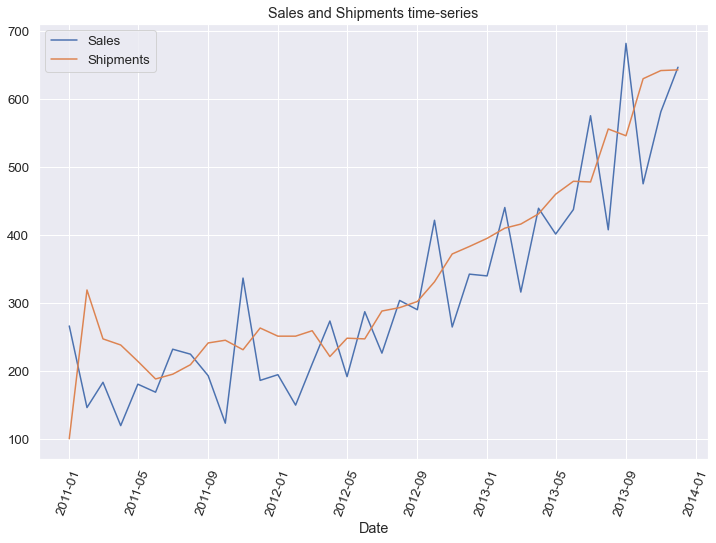

In [14]:
sns.set_style('darkgrid')
sns.set(font_scale = 1.2)

plt.figure(figsize=(12,8))
plt.title('Sales and Shipments time-series')
sns.lineplot(x='Date', y='Sales', data=data, label='Sales')
sns.lineplot(x='Date', y='Shipments', data=data, label='Shipments')
plt.legend()
plt.ylabel('')
plt.xticks(rotation=70);

- Since we have `BlackFridays` each November we would expect increasing of `Sales` this month. This graph hardly tells us that `Sales` increase each November, so we'll do time-series decomposition to clearly see the trend and seasonality.
- Sometimes `Shipments` are less than `Sales`, that may mean we have goods in stock.

### Time-series components

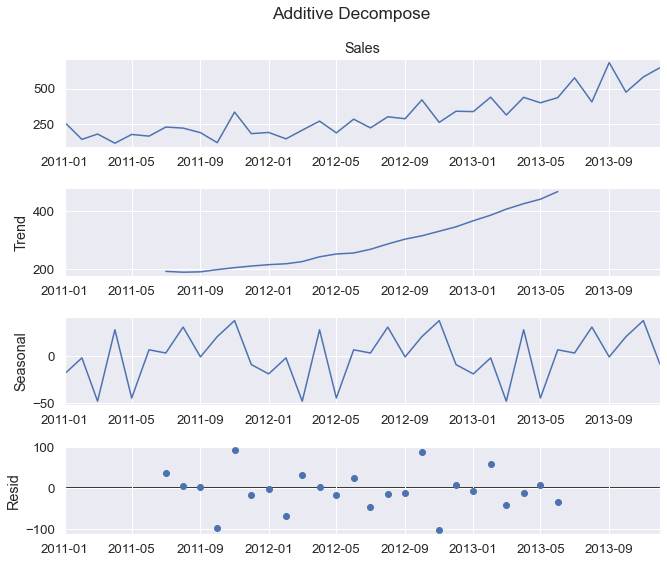

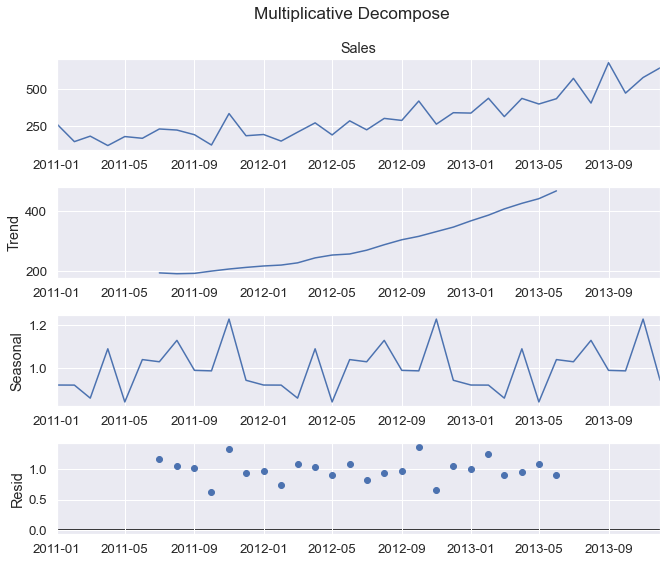

In [194]:
sales_decomp_add = seasonal_decompose(pos_data.Sales)
sales_decomp_mul = seasonal_decompose(pos_data.Sales, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

sales_decomp_add.plot().suptitle('Additive Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])

sales_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

We clearly see upward trend and some spikes in November (due to BlackFridays), April (probably due to Easter).

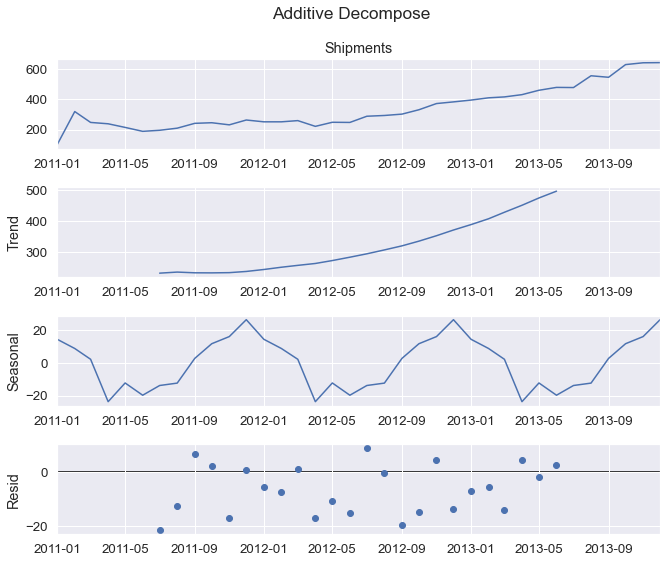

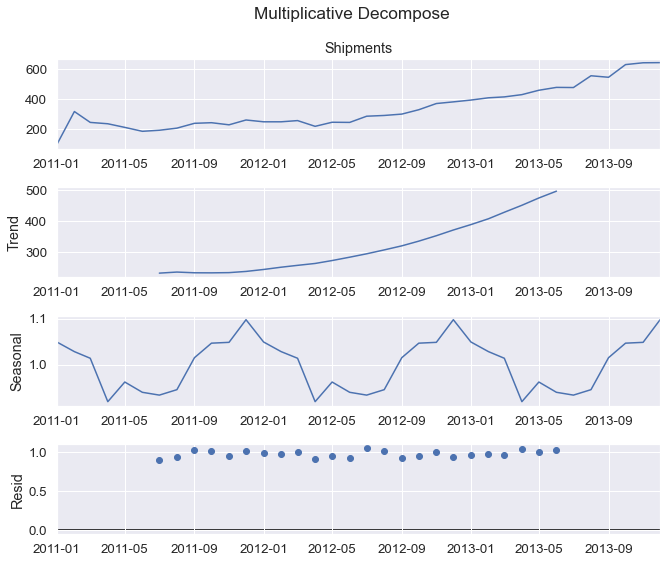

In [195]:
shipment_decomp_add = seasonal_decompose(shipment_data.Shipments)
shipment_decomp_mul = seasonal_decompose(shipment_data.Shipments, model='multiplicative')
plt.rcParams.update({'figure.figsize': (10,8)})

shipment_decomp_add.plot().suptitle('Additive Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])

shipment_decomp_mul.plot().suptitle('Multiplicative Decompose')
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

There's also upward trend and spikes are in May and December. I may assume that Shipments increases these month to replenish stock after big Sales in April and November.

## Moving average

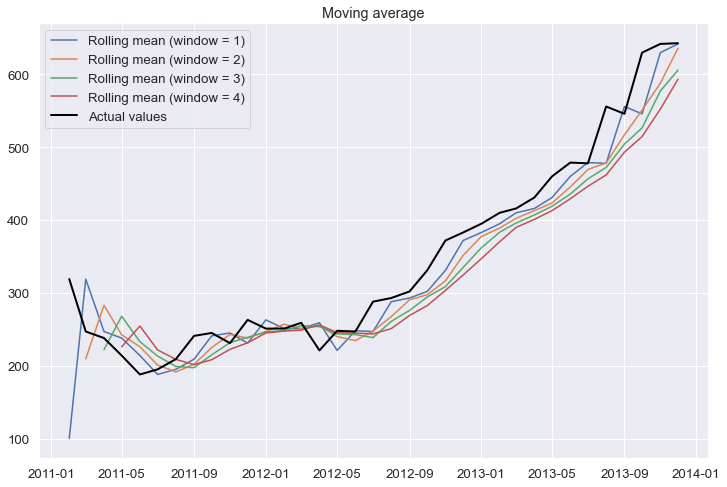

,1,2,3,4
mape,0.086088,0.083432,0.094687,0.107808
mae,27.342857,27.470588,33.010101,39.023438


In [18]:
window_sizes = [1, 2, 3, 4]

mae_errors, mape_errors = [], []

plt.figure(figsize=(12,8))
plt.title('Moving average')

for window in window_sizes:
    rolling_mean = data.Shipments.rolling(window=window).mean().shift(1)
    plt.plot(rolling_mean, label='Rolling mean (window = {})'.format(window))
    
    mae_errors.append(mae(data.Shipments[window:], rolling_mean[window:]))
    mape_errors.append(mape(data.Shipments[window:], rolling_mean[window:]))

plt.plot(data.Shipments[1:], label='Actual values', color='black', linewidth=2)
plt.legend(loc='best')
plt.show()

df_metrics = pd.DataFrame({'mape':mape_errors, 
                           'mae':mae_errors
                          }).T
df_metrics.columns = window_sizes
display(df_metrics)

The window of 1 means that `Shipments` in the next month will be the same as in the past. Comparing error metric MAPE we see that with the window of 2 we get better results, so for making a forecast of `Shipments` in the next month we would rely more on the last 2 months. The more the window size, the more data are involved in the calculation of the average, respectively, the smoother the curve is obtained and results are less accurate.

## Exponential Smoothing

Now let's weight all available observations while exponentially decreasing the weights as we move further back in time. We'll start with simple idea of exponential smoothing.

### Simple exponential smoothing

The mathematical notation for this method is: $$\hat{y}_x = \alpha y_x + (1 - \alpha)\hat{y}_{x-1}$$ 

So we pick an  $0 < \alpha < 1$ (also called **the smoothing factor**) and a starting value $\hat{y}_0$ (the first value of the observed data) and then calculate $\hat{y}_x$ for $x = \overline{1, n}$ (also referred to as **levels**). <br> $\alpha$ defines **how quickly we forget the last available true observation.** The smaller $\alpha$ is, the more influence the previous historical observations have and the smoother the series is, whereas larger values of $\alpha$ mean that the model pays attention mainly to the most recent past observations.

In [310]:
model = ExponentialSmoothing(data.Shipments.values, trend='additive')

In [ ]:
model.fit

In [333]:
def exp_smooth_score(x):
    mape_errors = []
    mae_errors = []
    predicted_values = []
    eval_result = {}
    values = data.Shipments.values
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 
    for train, test in tscv.split(values):
        
        if len(x) == 1:
            alpha = x
            model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha)
        elif len(x) == 2:
            alpha, beta = x
            model = ExponentialSmoothing(values[train], trend='mul').fit(smoothing_level=alpha, smoothing_trend=beta, method='basinhopping')
            # model = ExponentialSmoothing(values[train], trend='additive').fit(smoothing_level=alpha, smoothing_trend=beta)

        else:
            alpha, beta, gamma = x
            model = ExponentialSmoothing(values[train], trend='additive', 
                                         seasonal='additive', seasonal_periods=12).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
        
        predictions = model.forecast(len(test)) 
        predicted_values.append(predictions)

        actual = values[test]
        mape_errors.append(mape(actual, predictions))
        mae_errors.append(mae(actual, predictions))
    
    eval_result['predicted'] = predicted_values
    eval_result['mape'] = mape_errors
    eval_result['mae'] = mae_errors

    return eval_result

In [22]:
def evaluate_mape(x):
    mape_errors = exp_smooth_score(x)['mape']
    return np.mean(np.array(mape_errors))

In [23]:
def plot_results(predicted_values, title):
    true_values = data.Shipments[-5:].values
    
    plt.figure(figsize=(12,8))
    plt.plot(data.Shipments[-5:].index.values, true_values, label='Actual')
    plt.plot(data.Shipments[-5:].index.values, predicted_values, label='Predicted')
    plt.tick_params(axis='x', rotation=70)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

#### Experimenting with parameters

In [24]:
alphas = [0.01, 0.1, 0.5, 0.9]
for alpha in alphas:
    exp_smooth = exp_smooth_score(np.array([alpha]))
    predicted_values = exp_smooth['predicted']
    mape_errors = exp_smooth['mape']
    mae_errors = exp_smooth['mae']
    print(f'For alpha = {alpha}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.01:
mape = 0.47635564903988376
mae = 288.31509151793796

For alpha = 0.1:
mape = 0.32656559385702755
mae = 197.42902456988492

For alpha = 0.5:
mape = 0.1053270264777536
mae = 63.352515522746785

For alpha = 0.9:
mape = 0.06279279029131443
mae = 37.50113142322573



Through our experiments with parameters we found out that alpha of 0.9 gives better results of the error metrics. So we'll try to minimize MAPE and we expect to get optimized value for alpha which is around 0.9.

#### Optimizing parameters

### basinhopping

In [326]:
from scipy.optimize import basinhopping

In [340]:
import datetime

In [341]:
a = datetime.datetime.now()
x = [0]
bnds = [(0, 1)]
minimizer_kwargs = {"method":"L-BFGS-B", "bounds":bnds}
result = basinhopping(evaluate_mape, x0=x, minimizer_kwargs=minimizer_kwargs)
b = datetime.datetime.now()
print('Algorithm time: ', b - a)

Algorithm time:  0:00:11.818034


In [342]:
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = evaluate_mape(solution)
print(solution, evaluation)

Status : ['requested number of basinhopping iterations completed successfully']
Total Evaluations: 976
[0.98021202] 0.06241466991374293


In [25]:
x = [0]
opt = minimize(evaluate_mape, x0=x, bounds = [(0, 1)])
opt.x

array([0.98021403])

In [26]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))

For alpha = 0.98021
mape: 0.062414669913881525
mae: 37.041289248712566



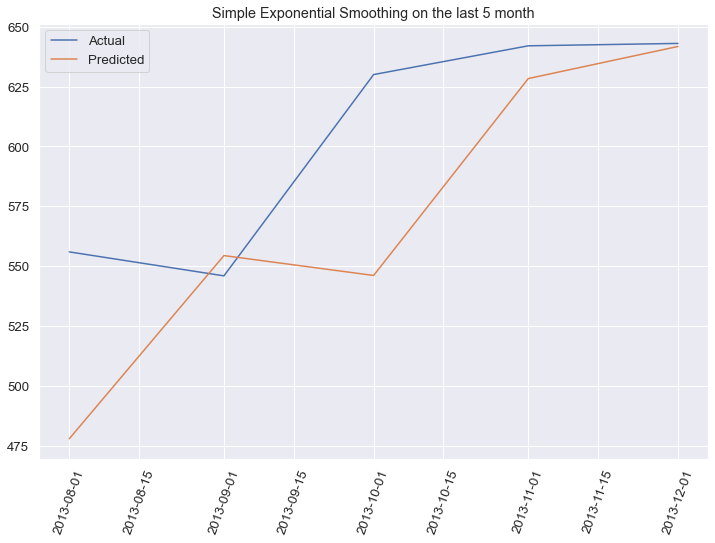

In [27]:
print(f'For alpha = {opt.x[0]:.5f}\nmape: {mape_score}\nmae: {mae_score}\n')
plot_results(predicted_values, title='Simple Exponential Smoothing on the last 5 month')

We minimized error metric MAPE and got an optimized value for alpha which is 0.98. The more the alpha in the Simple Exponential Smoothing method, the more we rely on the recent historic observations.

### Double exponential smoothing

Double Exponential Smoothing is an extension to Simple Exponential Smoothing that **explicitly adds support for trends** in the univariate time series. In addition to the $\alpha$ parameter for controlling smoothing factor for the level, an additional smoothing factor is added to control the decay of the influence of the change in trend - $\beta$. <br> Before we dive deeeper into mathematical formulas, let's introduce two notations: **the current trend**, denoted by $b$ (we can think of it as the slope of the time series), and **the current level**, denoted by $l$. 

Some math behind this idea: 
$$l_x = \alpha y_x + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$\hat{y}_{x+1} = l_x + b_x$$ 

- $l$, level is simply predicted point. It's a part of calculation of the forecast.
- Bigger values of $0<\beta<1$ mean that the model don't give much weight to the past trends when estimating current trend.
- The method supports **trend that changes in different ways: an additive and a multiplicative**, depending on whether the trend is linear or exponential respectively. Double Exponential Smoothing with an additive trend is classically referred to as **Holt’s linear trend model**. To compute the initial additive trend we may use the first two points: $y_x - y_{x-1}$. When the trend is multiplicative we could use the ratio $y_x / y_{x-1}$.

#### Experimenting with parameters

In [241]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        exp_smooth = exp_smooth_score([alpha, beta])
        predicted_values = exp_smooth['predicted']
        mape_errors = exp_smooth['mape']
        mae_errors = exp_smooth['mae']
        print(f'For alpha = {alpha}, beta = {beta}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1:
mape = 0.17898075337562527
mae = 108.30503221508145

For alpha = 0.1, beta = 0.9:
mape = 0.04056254828129298
mae = 24.72361767770992

For alpha = 0.9, beta = 0.1:
mape = 0.05979246964146202
mae = 35.3946911543365

For alpha = 0.9, beta = 0.9:
mape = 0.09536828032905528
mae = 56.45478104721102



In [322]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        exp_smooth = exp_smooth_score([alpha, beta])
        predicted_values = exp_smooth['predicted']
        mape_errors = exp_smooth['mape']
        mae_errors = exp_smooth['mae']
        print(f'For alpha = {alpha}, beta = {beta}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1:
mape = 0.11517811330469448
mae = 69.5517445946588

For alpha = 0.1, beta = 0.9:
mape = 0.033156231767438905
mae = 19.729471904590447

For alpha = 0.9, beta = 0.1:
mape = 0.06511165332835553
mae = 38.71651737968875

For alpha = 0.9, beta = 0.9:
mape = 0.10112372510140591
mae = 59.86301180067132



In [ ]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        exp_smooth = exp_smooth_score([alpha, beta])
        predicted_values = exp_smooth['predicted']
        mape_errors = exp_smooth['mape']
        mae_errors = exp_smooth['mae']
        print(f'For alpha = {alpha}, beta = {beta}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1:
mape = 0.11517810925654315
mae = 69.55172322043134

For alpha = 0.1, beta = 0.9:
mape = 0.03315612591583266
mae = 19.729412534546782

For alpha = 0.9, beta = 0.1:
mape = 0.06511164689319157
mae = 38.71651386760497

For alpha = 0.9, beta = 0.9:
mape = 0.10112372510140591
mae = 59.86301180067132



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/s

Through our experiments with parameters we found out that alpha of 0.1 and beta of 0.9 give better results of the error metrics. So we'll try to minimize MAPE and we expect to get optimized value for alpha and beta which are around 0.1 and 0.9 respectively.

#### Optimizing parameters

### basinhopping

In [343]:
a = datetime.datetime.now()
x = [0, 0]
bnds = ((0, 1), (0, 1))
minimizer_kwargs = {"method":"L-BFGS-B", "bounds":bnds}
result = basinhopping(evaluate_mape, x0=x, minimizer_kwargs=minimizer_kwargs)
b = datetime.datetime.now()
print('Algorithm time: ', b - a)

Algorithm time:  0:03:55.202369


In [336]:
print('Status : %s' % result['message'])
print('Total Evaluations: %d' % result['nfev'])
# evaluate solution
solution = result['x']
evaluation = evaluate_mape(solution)
print(solution, evaluation)

Status : ['requested number of basinhopping iterations completed successfully']
Total Evaluations: 10836
[0.08045643 0.99515457] 0.03834631821433734


In [199]:
x = [0, 0]
opt = minimize(evaluate_mape, x0=x, bounds = ((0, 1), (0, 1)))
opt.x

array([0., 0.])

In [200]:
exp_smooth = exp_smooth_score(opt.x)
mape_score = np.mean(np.array(exp_smooth['mape']))
mape_score

0.3434647068756652

We tried to minimize MAPE but the optimized parameters are far from those that we experiment with. Moreover it didn't seem that we minimized our MAPE. I may assume that we found local minimum instead of global, so let's try to adjust parameters to 0.1 and 0.9 to get less value of MAPE.

In [218]:
x = [0.09, 0.8]
opt = minimize(evaluate_mape, x0=x, bounds = ((0.09, 1), (0.8, 1)))
opt.x

array([0.09      , 0.92699101])

In [219]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))
mape_score

0.03905631284593765

For alpha = 0.09000, beta = 0.92699
mape: 0.03905631284593765
mae: 23.732592705391404


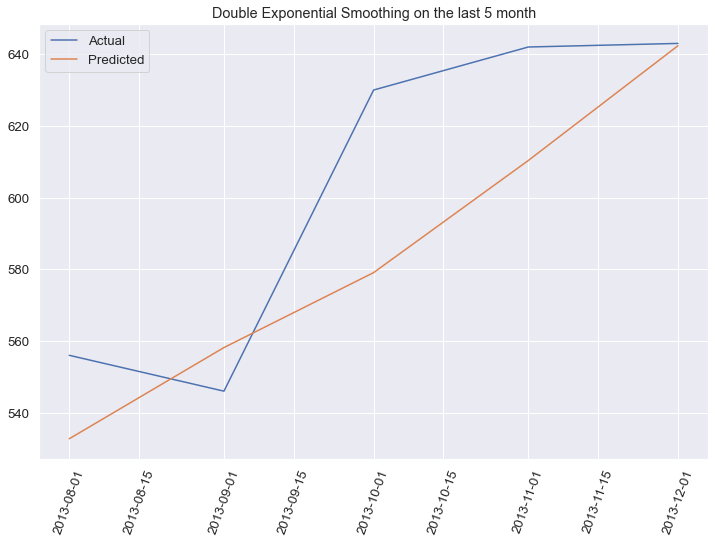

In [220]:
alpha, beta = opt.x
print(f'For alpha = {alpha:.5f}, beta = {beta:.5f}\nmape: {mape_score}\nmae: {mae_score}')

plot_results(predicted_values, title='Double Exponential Smoothing on the last 5 month')

So we got optimized alpha and beta which are very close to 0.1 and 0.9 respectively. Indeed we minimized MAPE, so now it's 3.9%, but can we do better?

### Triple exponential smoothing

The idea behind this method (also called **Holt-Winters Method**) is to apply Exponential Smoothing to a third component - **seasonality**, $s$. This seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words, by the period which the variations repeats itself. So for each observation in the season, there will be a separate component. 
<br> The mathematical notation for this method is:
$$l_x = \alpha (y_x - s_{x-L}) + (1 - \alpha)(l_{x-1} + b_{x-1})$$ 
$$b_x = \beta(l_x - l_{x-1}) + (1 - \beta)b_{x-1}$$ 
$$s_x = \gamma(y_x - l_{x}) + (1 - \gamma)s_{x-L}$$ 
$$\hat{y}_{x+m} = l_x + m b_x + s_{x-L+(m-1)modL}$$

- $L$, season length is the number of data points after which a new season begins.
- There is a new parameter  $0<\gamma<1$ that controls the influence on the seasonal component.
- The index for the forecast $\hat{y}_{x+m}$ is $x+m$ where $m$ can be any integer. It means we can forecast any number of points into the future while accounting for previous value, trend and seasonality.
- The index of the seasonal component $s_{x-L+(m-1)modL}$ offsets into our observed data list of seasonal components. 
<br> For example, if we are forecasting the 3rd point into the season, and we are 12 seasons into the future, we cannot use seasonal components from the 11th season in the future since that season is also generated by our forecasting procedure, we must use the last set of seasonal components from observed points, or from "the past".


**Initial values for the trend factor**
<br>The most common practice here is to compute the average trend averages across seasons:
$$b = \frac{1}{L}(\frac{y_{L+1} - y_1}{L} + \frac{y_{L+2} - y_2}{L} + \ldots + \frac{y_{L+L} - y_L}{L})$$

**Initial values for the seasonal indices**
<br> We need:
- to compute the averages for every observed season 
- to subtract every observed value by the average for the season it's in
- to  average each of these numbers across our observed seasons

#### Experimenting with parameters

In [221]:
alphas = [0.1, 0.9]
betas = [0.1, 0.9]
gammas = [0.1, 0.9]

for alpha in alphas:
    for beta in betas:
        for gamma in gammas:
            exp_smooth = exp_smooth_score([alpha, beta, gamma])
            predicted_values = exp_smooth['predicted']
            mape_errors = exp_smooth['mape']
            mae_errors = exp_smooth['mae']
            print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}:\nmape = {np.mean(np.array(mape_errors))}\nmae = {np.mean(np.array(mae_errors))}\n')

For alpha = 0.1, beta = 0.1, gamma = 0.1:
mape = 0.19766452293052322
mae = 119.07714569131397

For alpha = 0.1, beta = 0.1, gamma = 0.9:
mape = 0.12666703197433962
mae = 75.6692087302075

For alpha = 0.1, beta = 0.9, gamma = 0.1:
mape = 0.04133565100066507
mae = 24.71858150472956

For alpha = 0.1, beta = 0.9, gamma = 0.9:
mape = 0.03394911438112824
mae = 20.55015256033239

For alpha = 0.9, beta = 0.1, gamma = 0.1:
mape = 0.0650079474613667
mae = 38.28636562176865

For alpha = 0.9, beta = 0.1, gamma = 0.9:
mape = 0.06431167578312247
mae = 37.4305357448214

For alpha = 0.9, beta = 0.9, gamma = 0.1:
mape = 0.10680373228871828
mae = 62.9366212074175

For alpha = 0.9, beta = 0.9, gamma = 0.9:
mape = 0.08716622628966794
mae = 50.531717990968126



Through our experiments with parameters we found out that alpha of 0.1, beta of 0.9 and gamma of 0.9 give better results of the error metrics. So we'll try to minimize MAPE and we expect to get optimized value for alpha, beta and gamma which are around 0.1, 0.9 and 0.9 respectively.

#### Optimizing parameters

In [222]:
x = [0, 0, 0]
opt = minimize(evaluate_mape, x0=x, bounds=((0, 1), (0, 1), (0, 1)))
opt.x

array([1.00000000e+00, 2.33181332e-06, 1.00000000e+00])

In [223]:
np.mean(np.array(exp_smooth_score(opt.x)['mape']))

0.06537506423570569

So our optimized parameters are not close to the values of 0.1, 0.9 and 0.9 as we expected to get. Let's adjust parameters to these values and see what MAPE we will get.

In [224]:
x = [0.09, 0.7, 0.7]
opt = minimize(evaluate_mape, x0=x, bounds=((0.09, 1), (0.7, 1), (0.7, 1)))
opt.x

array([0.09, 0.7 , 1.  ])

In [225]:
exp_smooth = exp_smooth_score(opt.x)
predicted_values = exp_smooth['predicted']
mape_score = np.mean(np.array(exp_smooth['mape']))
mae_score = np.mean(np.array(exp_smooth['mae']))
mape_score

0.033408261652010544

For alpha = 0.09, beta = 0.7, gamma = 1.0
mape: 0.033408261652010544
mae: 20.283248053222565



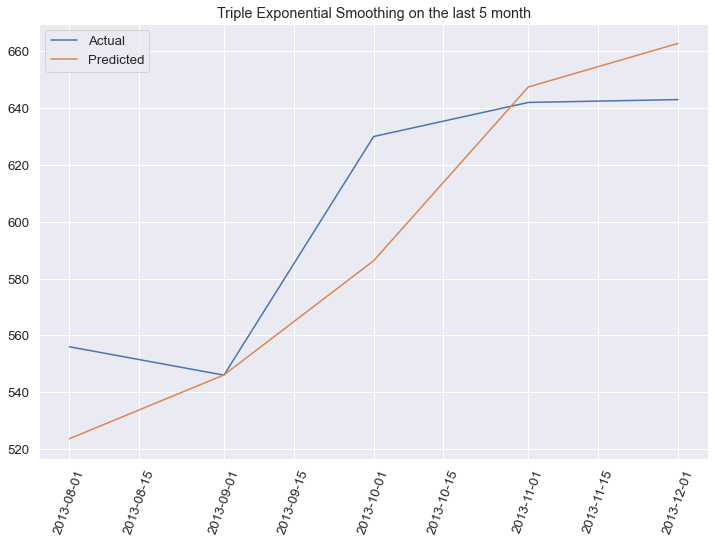

In [226]:
alpha, beta, gamma = opt.x
print(f'For alpha = {alpha}, beta = {beta}, gamma = {gamma}\nmape: {mape_score}\nmae: {mae_score}\n')

plot_results(predicted_values, title='Triple Exponential Smoothing on the last 5 month')

As we adjusted our parameters we got better result for MAPE - 3.34%. So now our model takes into account trend and seasonality and we see from the graph above the smaller gap between actual and predicted values from September to December.

## Linear regression using Lag features

### Use two lags - initial model

In [40]:
data_lag = data.copy()
data_lag['Lag_sales'] = data_lag['Sales'].shift(periods=2)
data_lag['Lag_shipments'] = data_lag['Shipments'].shift(periods=1)
data_lag.dropna(inplace=True)

X, y = data_lag[['Lag_sales', 'BlackFriday', 'Lag_shipments']], data_lag[['Shipments']]

In [41]:
def evaluate(model, X, y):
    tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(X):
        model.fit(X.values[train], y.values[train])
        prediction = model.predict(X.values[test])
        predicted_values.append(prediction[0])
    
        mae_errors.append(mae(y.values[test], prediction))
        mape_errors.append(mape(y.values[test], prediction))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

In [42]:
lin_reg = LinearRegression()

mape = 0.0846821898595995
mae = 50.4684543985219



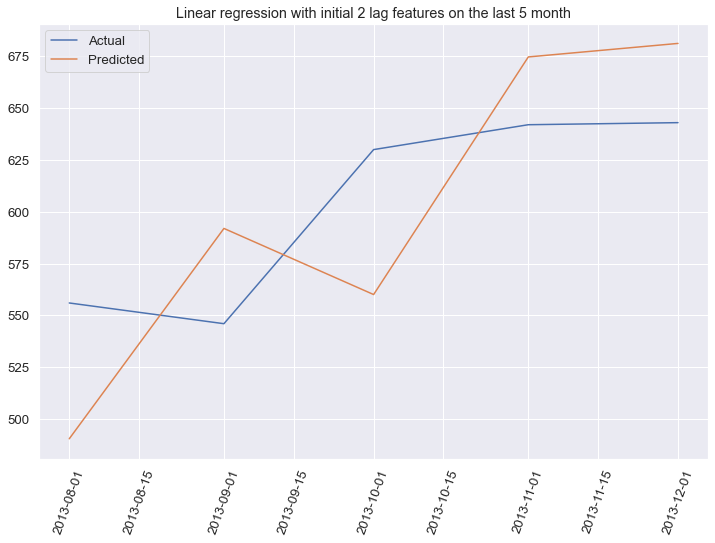

In [43]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(predicted_values, title='Linear regression with initial 2 lag features on the last 5 month')

So we used `Shipments` for the last month and `Sales` for the 2nd last month and got MAPE of 8.47%. It can make sense to choose lags of `Shipments` and `Sales` more careful. Let's try different techniques to choose lags and compare MAPE.

### Choose more lags from Partial Autocorrelation plot

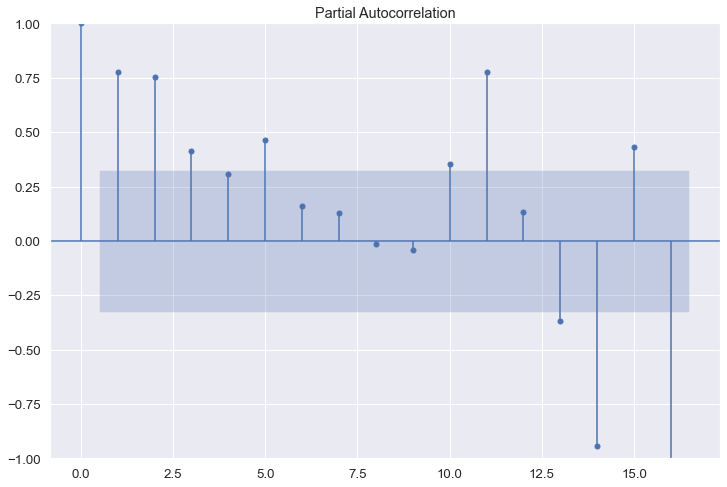

In [44]:
plot_pacf(data.Sales, method='ols') 
plt.show()

When we predict `Shipments` in the next month, we don't know yet about `Sales` in the last month. So we'll choose 2, 3, 5, 11, 14, 15, 16 lags.

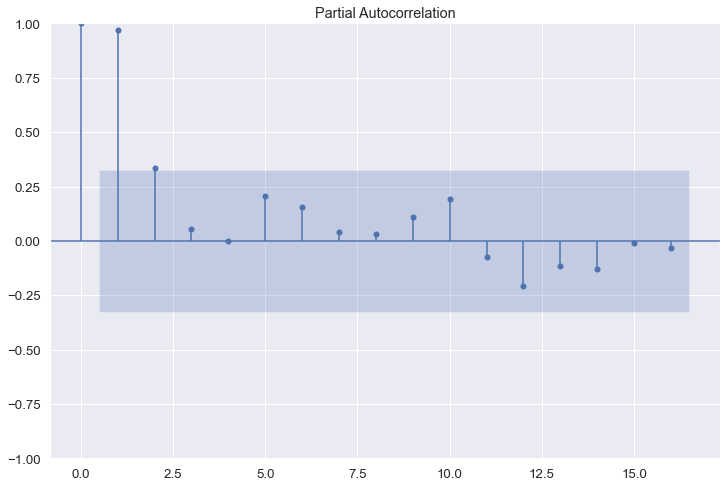

In [45]:
plot_pacf(data.Shipments, method='ols') 
plt.show()

We'll choose 1 lag for `Shipments`.

In [46]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'{ts.name}_lag_{i}': ts.shift(i)
            for i in lags
        },
        axis=1)

In [47]:
data_lag = data.copy()
X = make_lags(data_lag.Sales, [2, 3, 5, 11, 14, 15, 16])
y = make_lags(data_lag.Shipments, [1])

In [48]:
res = pd.concat([X, y], axis=1)
res.fillna(0, inplace=True)
res = pd.concat([res, data_lag[['BlackFriday']]], axis=1)

In [49]:
X, y = res, data_lag[['Shipments']]

mape = 0.09402198545369067
mae = 56.2011125645015



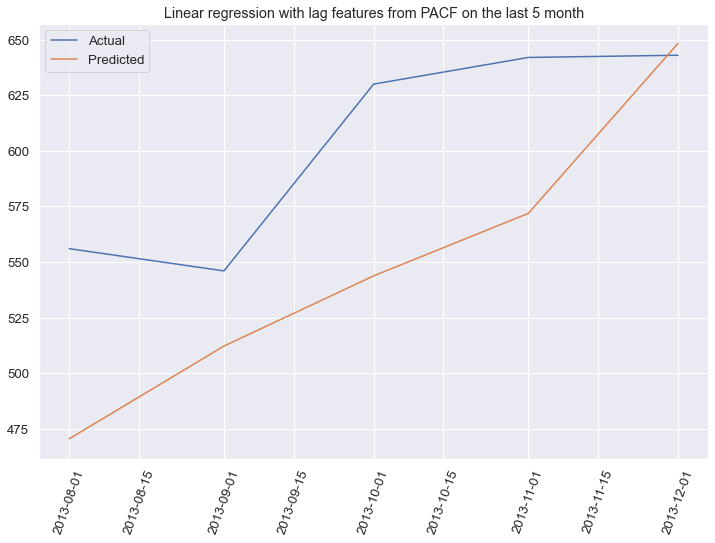

In [50]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(predicted_values, title='Linear regression with lag features from PACF on the last 5 month')

### With Feature Selection technique

#### Lasso + SelectFromModel

In [51]:
data_lag = data.copy()

sales_lags_count = list(range(2, 17))
shipments_lags_count = list(range(1, 17))
sales_lags = make_lags(data_lag.Sales, sales_lags_count)
shipments_lags = make_lags(data_lag.Shipments, shipments_lags_count)

res = pd.concat([sales_lags, shipments_lags], axis=1)

In [52]:
scaler = StandardScaler()
res_scaled = pd.DataFrame(scaler.fit_transform(res[:-5]), columns=res.columns)

df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[:-5].reset_index(drop=True)], axis=1)
df_scaled.fillna(0, inplace=True)

In [53]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])

In [54]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model, prefit=True)

In [55]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

['Sales_lag_2',
 'Sales_lag_3',
 'Sales_lag_4',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3']

In [56]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)
reduced_data.fillna(0, inplace=True)

In [57]:
X, y = reduced_data, data_lag['Shipments']

mape = 0.07573257282850883
mae = 44.86199302760569



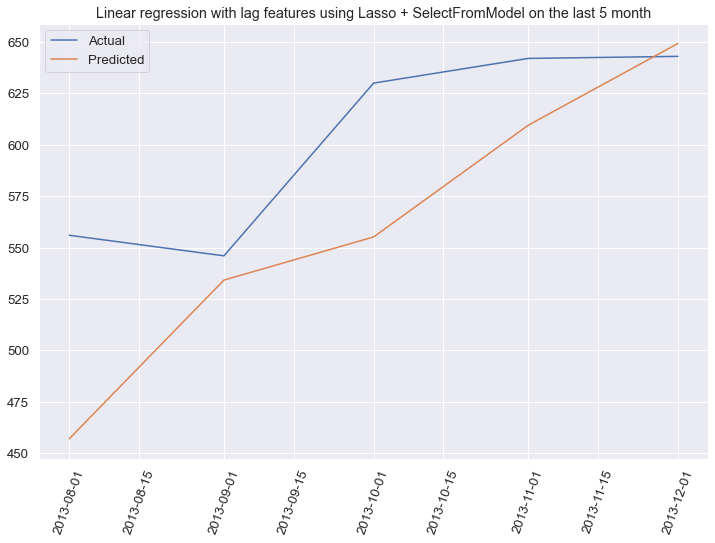

In [58]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(predicted_values, title='Linear regression with lag features using Lasso + SelectFromModel on the last 5 month')

So we took into account lags till 16 and replaced NaN values with zero. After that we applied Lasso as our selection model and SelectFromModel teqnique. As Lasso produces zero coefficients it's expected to see that there are only first 3 lags of `Sales` and `Shipments` to keep. Let's look at the sparse matrix of coeffitients that Lasso gives.

In [59]:
selection_model.coef_

array([ 0.26629174,  0.23305483,  0.08886399,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.00994359,  0.25604667,  0.09930753,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ])

Indeed the last lags are considered to be less important by Lasso model because we manually filled NaNs with zeros. But let's see the result when we fill the missing values with mean value of trained observations.

In [60]:
scaler = StandardScaler()
res_scaled = pd.DataFrame(scaler.fit_transform(res[:-5]), columns=res.columns)

df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[:-5].reset_index(drop=True)], axis=1)
df_scaled.fillna(df_scaled[:-5].mean(), inplace=True)

In [61]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])

In [62]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model, prefit=True)

In [63]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

['Sales_lag_2',
 'Sales_lag_3',
 'Sales_lag_4',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4',
 'Shipments_lag_10']

In [64]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)
reduced_data.fillna(reduced_data[:-5].mean(), inplace=True)

In [65]:
X, y = reduced_data, data_lag['Shipments']

mape = 0.05809890255770154
mae = 34.679528225308424



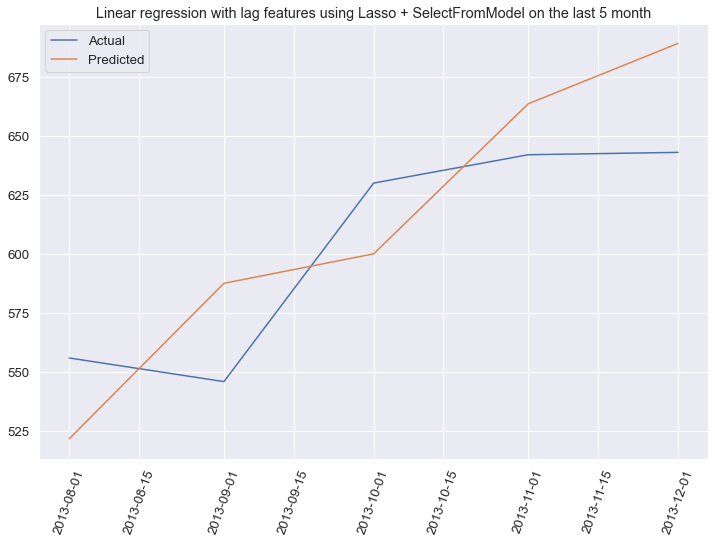

In [66]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(predicted_values, title='Linear regression with lag features using Lasso + SelectFromModel on the last 5 month')

Now we got better result for MAPE. Also we see the difference in the columns to keep. So lags for `Sales` are the same as previous, but not for `Shipments`. So let's look again at the sparse matrix of coefficients. 

In [67]:
selection_model.coef_

array([ 0.26655963,  0.25511617,  0.1171205 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.20548574,  0.10108944,  0.03001943,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00916595,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

Though the coefficient of `Shipments` lag of 10 is much less than others non-zero coeffitients, this lag is considered to be important. 
<br> Now let's fill NaNs with median value of trained observations.

In [68]:
df_scaled = pd.concat([res_scaled, data_lag.BlackFriday[:-5].reset_index(drop=True)], axis=1)
df_scaled.fillna(df_scaled[:-5].median(), inplace=True)

In [69]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])

In [70]:
selection_model = Lasso(alpha=0.1).fit(X, y)
model = SelectFromModel(selection_model, prefit=True)

In [71]:
columns_to_keep = df_scaled.columns[model.get_support()].values.tolist()
columns_to_keep

['Sales_lag_2',
 'Sales_lag_3',
 'Sales_lag_4',
 'Sales_lag_5',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4']

In [72]:
delete = [c for c in res.columns.values.tolist() if c not in columns_to_keep]
reduced_data = res.drop(delete, axis=1)
reduced_data.fillna(reduced_data[:-5].median(), inplace=True)

In [73]:
X, y = reduced_data, data_lag['Shipments']

mape = 0.04994183612770979
mae = 29.780234614114214



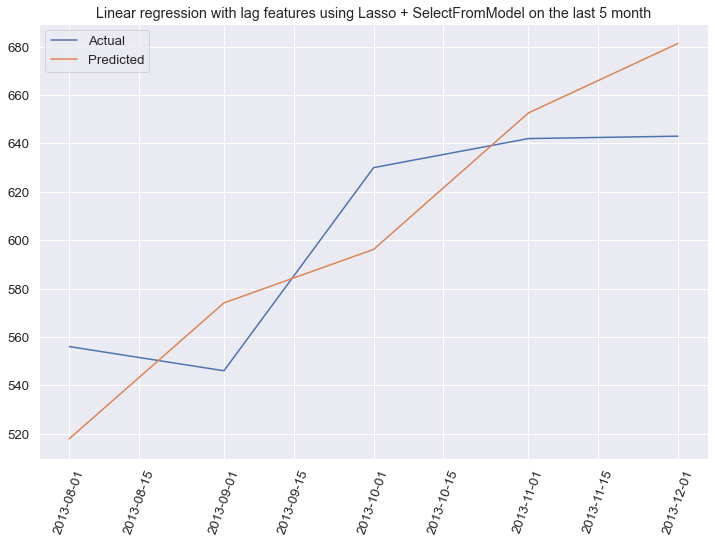

In [74]:
predicted_values = evaluate(lin_reg, X, y)
plot_results(predicted_values, title='Linear regression with lag features using Lasso + SelectFromModel on the last 5 month')

So the results of MAPE are even better when we replaced missing values with median. Let's try to tunned Lasso parameters to get better result.

#### GridSearch + Lasso

In [75]:
parameters = {
    'alpha': np.linspace(0.1, 1, 10), 
    'fit_intercept':['True', 'False'],
    'max_iter': np.linspace(100, 1500, 8),
    'tol':np.linspace(0.0001, 0.001, 4)
}

In [76]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(Lasso(), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

In [77]:
X, y = df_scaled, scaler.fit_transform(data_lag[['Shipments']][:-5])
grid_result = grid.fit(X, y)

In [78]:
grid_result.best_params_

{'alpha': 0.1, 'fit_intercept': 'True', 'max_iter': 100.0, 'tol': 0.0001}

So as the best parameters of GridSearch are the same that we used previously with Lasso model, we'll move on and try another selection technique Boruta.

#### RandomForestRegressor + Boruta

In [79]:
forest = RandomForestRegressor(
    n_jobs=-1, 
    max_depth=5,
    random_state=42
)
boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100 
)

In [80]:
# res = pd.concat([res, data_lag.BlackFriday], axis=1).fillna(0)
res = pd.concat([res, data_lag.BlackFriday], axis=1).fillna(res[:-5].mean())
X, y = res, data_lag['Shipments']

In [81]:
X_train, y_train = X[:-5], y[:-5]
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=74,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FEE2C5C2140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FEE2C5C2140)

In [82]:
cols = X.columns[boruta.support_].to_list()
cols

['Sales_lag_2',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4']

In [83]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

mape = 0.06369570120924992
mae = 38.14668844738834



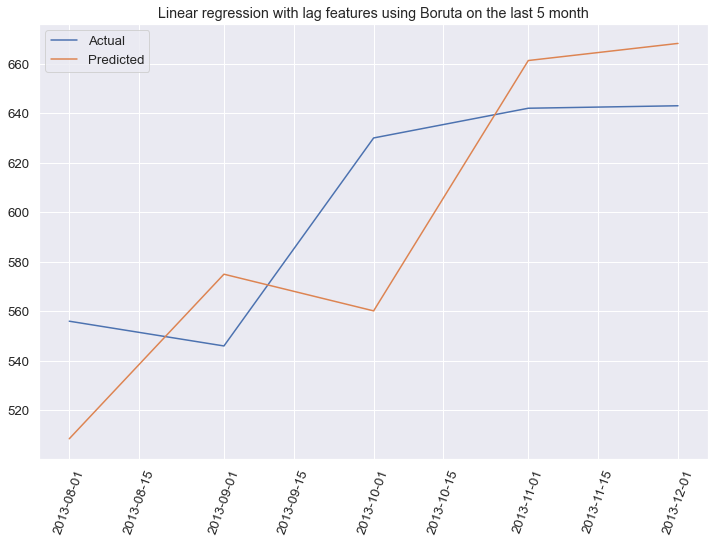

In [84]:
predicted_values = evaluate(lin_reg, reduced_data, data_lag['Shipments'])
plot_results(predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

Result of MAPE is close to one we got using Lasso + SelectFromModel. I assume that tunning parameters may help to achieve better results of error metrics. Let's check it.

#### GridSearch + RandomForestRegressor

In [85]:
parameters = {
    'n_estimators': [10, 40, 70, 100, 130],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_depth': [3, 7, 11, 15],
    'min_samples_split': [2, 4, 6]
}

In [86]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), 
                    parameters, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

grid_result = grid.fit(X_train, y_train)

In [87]:
grid_result.best_params_

{'criterion': 'poisson',
 'max_depth': 11,
 'min_samples_split': 2,
 'n_estimators': 10}

In [93]:
forest = RandomForestRegressor(**grid_result.best_params_, random_state=42)

boruta = BorutaPy(
    estimator=forest, 
    n_estimators='auto',
    max_iter=100 
)

In [94]:
boruta.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestRegressor(criterion='poisson', max_depth=11,
                                         n_estimators=44,
                                         random_state=RandomState(MT19937) at 0x7FEE2C5C2140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FEE2C5C2140)

In [95]:
cols = X.columns[boruta.support_].to_list()
cols

['Sales_lag_4',
 'Shipments_lag_1',
 'Shipments_lag_2',
 'Shipments_lag_3',
 'Shipments_lag_4',
 'Shipments_lag_5',
 'Shipments_lag_6']

In [96]:
delete = [c for c in res.columns.values.tolist() if c not in cols]
reduced_data = res.drop(delete, axis=1)

mape = 0.03896825800693908
mae = 23.639664525794434



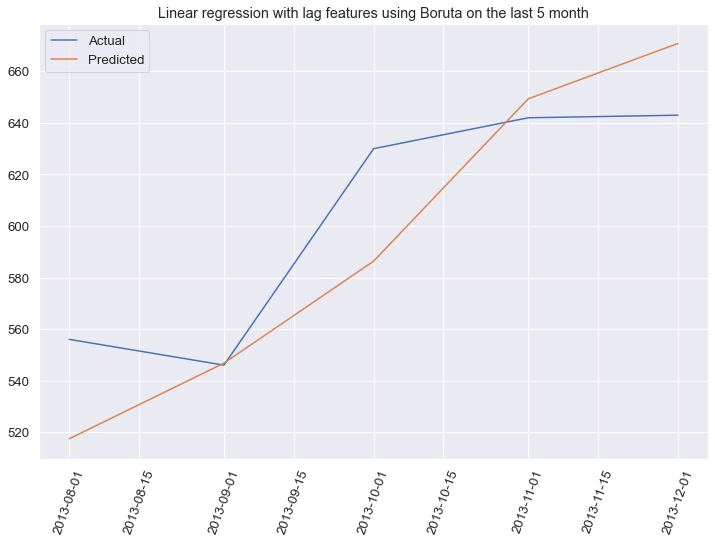

In [97]:
predicted_values = evaluate(lin_reg, reduced_data, data_lag['Shipments'])
plot_results(predicted_values, title='Linear regression with lag features using Boruta on the last 5 month')

So far we got two best results of MAPE. 3.34% using Holt-Winters Exponential Smoothing model and 3.89% using Linear Regression with Boruta.

Now let's try other models on those columns Boruta selected above.

## Gradient Boosting libraries

### XGBoost

In [98]:
params = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 7, 9],
        'eta': [0.1, 0.3, 0.5, 0.7, 1]
        }

In [99]:
tscv = TimeSeriesSplit(n_splits=5, test_size=1) 

grid = GridSearchCV(xgb.XGBRegressor(random_state=42), 
                    params, 
                    cv=tscv, 
                    scoring='neg_mean_absolute_percentage_error')

X_train, y_train = reduced_data[:-5], data_lag.Shipments[:-5]
grid_result = grid.fit(X_train, y_train)

In [100]:
grid_result.best_params_

{'eta': 1, 'max_depth': 7, 'n_estimators': 50}

In [101]:
xgb_reg = xgb.XGBRegressor(**grid_result.best_params_)

mape = 0.06368146221389606
mae = 37.87298583984375



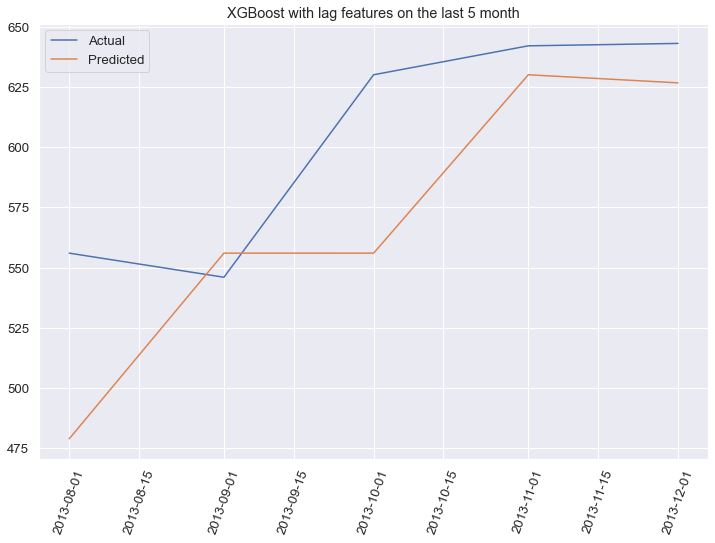

In [104]:
predicted_values = evaluate(xgb_reg, reduced_data, data_lag['Shipments'])
plot_results(predicted_values, title='XGBoost with lag features on the last 5 month')

## Phrophet

In [ ]:
data_prophet = data.copy()

In [ ]:
data_prophet.reset_index(inplace=True)
data_prophet = data_prophet.rename(columns = {'Date': 'ds',
                                              'Shipments': 'y'})
data_prophet = data_prophet.loc[:, ['ds', 'y']]

### Initial prophet

In [ ]:
def validate_prophet(holidays=None):
    values = data_prophet.values
    tscv = TimeSeriesSplit(n_splits=5, test_size=1, gap=1) 

    mae_errors, mape_errors = [], []
    predicted_values = []
    for train, test in tscv.split(values):
        df_train = pd.DataFrame(values[train]).rename(columns = {0: 'ds', 1: 'y'})
        model = Prophet(holidays=holidays)
        model.fit(df_train)
    
        future_date = pd.DataFrame(data_prophet.iloc[test[0]]).T[['ds']]
        prediction = model.predict(future_date)
        predicted_values.append(prediction.yhat)
    
        mae_errors.append(mae(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
        mape_errors.append(mape(np.array([data_prophet.iloc[test[0]].values[1]]), np.array([prediction.yhat.values[0]])))
    
    mae_errors = np.mean(np.array(mae_errors))
    mape_errors = np.mean(np.array(mape_errors))

    print(f'mape = {mape_errors}\nmae = {mae_errors}\n')
    return predicted_values

In [ ]:
predicted_init = validate_prophet()

### Phrophet with holidays

In [ ]:
black_friday = promo_data.reset_index()
black_friday.columns = ['ds', 'holiday']

predicted_adv = validate_prophet(holidays=black_friday)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(true_values, label='Actual')
plt.plot(predicted_init, label='Predicted (initial)')
plt.plot(predicted_adv, label='Predicted (with holidays)')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing on the last 5 month')
plt.show()